In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


In [4]:
   
db = CaseDB()
toload = [
    dict(name="afnE", id = "d24b-tunefrec_E_AFN_mfp1.0"),
    dict(name="afnE_cond0.01", id = "d27-d24bf_copy_cond0.01_frec0.68"),
    dict(name="afnE_cond0.01_minmod_form1", id = "d27ba-cond0.01_frec0.68_MinMod_diagPd"),
    dict(name="afnE_cond0.01_minmod_form3", id = "d27d-form3_no53_addcompr"),
    dict(name="afnE_cond0.01_minmod_form2", id = "d27bb-minmod_form2_no53_factor"),
    dict(name="afnE_cond0.25_form1", id = "d28a-d24bd_copy_cond0.25_frec0.48"),
    dict(name="afnE_cond0.25_form2", id = "d28b-form2_no53_factor"),
    dict(name="afnE_cond0.25_form3", id = "d28c-form3_no53_addcompr"),
    dict(name="afnE_cond0.25_form4", id = "d28e-form4_full_v_grad_p"),
    dict(name="noafn_old", id = "d27c-no_afn"),
    dict(name="noafn_new", id = "d28d-noafn"),
    dict(name="afnE_cond0.25_CXx0.75", id = "d29a-cond0.25_frec0.48_CXx0.75"),
    dict(name="afnE_cond0.25_IZx0.75", id = "d29b-cond0.25_frec0.48_IZx0.75"),
]
casestore = {}
for case in toload:
    casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True, use_xhermes=False)

- Reading case d24b-tunefrec_E_AFN_mfp1.0
-----------------------
- Looking for squash file
- Squash file found. squash date 10/15/2023, 22:03:01, dmp file date 10/13/2023, 18:12:51

- Reading case d27-d24bf_copy_cond0.01_frec0.68
-----------------------
- Looking for squash file
- Squash file found. squash date 10/20/2023, 15:37:25, dmp file date 10/20/2023, 15:19:01

- Reading case d27ba-cond0.01_frec0.68_MinMod_diagPd
-----------------------
- Looking for squash file
- Squash file found. squash date 11/10/2023, 11:19:15, dmp file date 11/10/2023, 11:15:33

- Reading case d27d-form3_no53_addcompr
-----------------------
- Looking for squash file
- Squash file found. squash date 11/17/2023, 13:22:20, dmp file date 11/17/2023, 00:56:17

- Reading case d27bb-minmod_form2_no53_factor
-----------------------
- Looking for squash file
- Squash file found. squash date 11/20/2023, 13:33:29, dmp file date 11/19/2023, 18:01:59

- Reading case d28a-d24bd_copy_cond0.25_frec0.48
-----------------

In [5]:
hr = dict()
for name in casestore.keys(): 
    print(name)
    hr[name] = Hermesdata()
    hr[name].read_case(casestore[name].ds.isel(t=-1, x = slice(2,-2)))
    
    if "afnE" in  name:
        new_afn = True
        print(f"Loading {name} with new AFN")
    else:
        new_afn = False
        print(f"Loading {name} with old AFN")
    
    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = new_afn)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

afnE
Loading afnE with new AFN
afnE_cond0.01
Loading afnE_cond0.01 with new AFN
afnE_cond0.01_minmod_form1
Loading afnE_cond0.01_minmod_form1 with new AFN
afnE_cond0.01_minmod_form3
Loading afnE_cond0.01_minmod_form3 with new AFN
afnE_cond0.01_minmod_form2
Loading afnE_cond0.01_minmod_form2 with new AFN
afnE_cond0.25_form1
Loading afnE_cond0.25_form1 with new AFN
afnE_cond0.25_form2
Loading afnE_cond0.25_form2 with new AFN
afnE_cond0.25_form3
Loading afnE_cond0.25_form3 with new AFN
afnE_cond0.25_form4
Loading afnE_cond0.25_form4 with new AFN
noafn_old
Loading noafn_old with old AFN
noafn_new
Loading noafn_new with old AFN
afnE_cond0.25_CXx0.75
Loading afnE_cond0.25_CXx0.75 with new AFN
afnE_cond0.25_IZx0.75
Loading afnE_cond0.25_IZx0.75 with new AFN


In [6]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

In [7]:
casestore.keys()

dict_keys(['afnE', 'afnE_cond0.01', 'afnE_cond0.01_minmod_form1', 'afnE_cond0.01_minmod_form3', 'afnE_cond0.01_minmod_form2', 'afnE_cond0.25_form1', 'afnE_cond0.25_form2', 'afnE_cond0.25_form3', 'afnE_cond0.25_form4', 'noafn_old', 'noafn_new', 'afnE_cond0.25_CXx0.75', 'afnE_cond0.25_IZx0.75'])

## Poloidal plots of all cases
- Looks like adding compression term doesn't make a difference
- Original form is worse than AFN form

C:\Users\mikek\AppData\Local\Temp\ipykernel_22652\496285887.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
C:\Users\mikek\AppData\Local\Temp\ipykernel_22652\496285887.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
C:\Users\mikek\AppData\Local\Temp\ipykernel_22652\496285887.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.

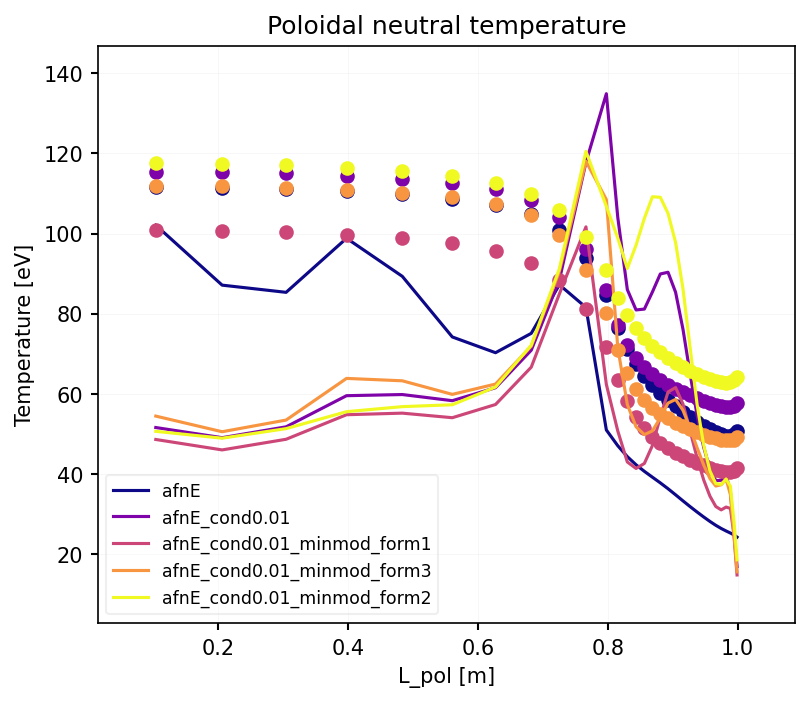

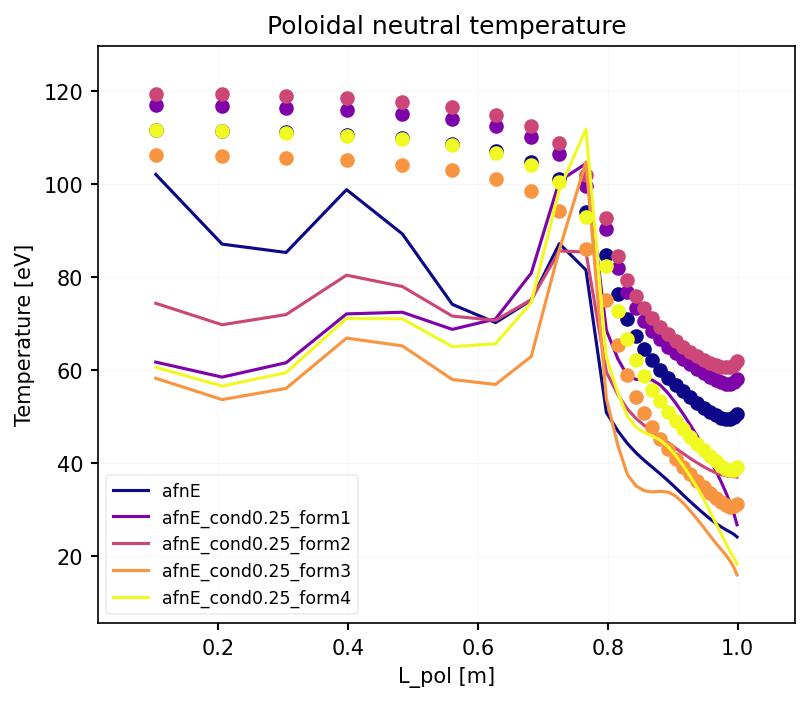

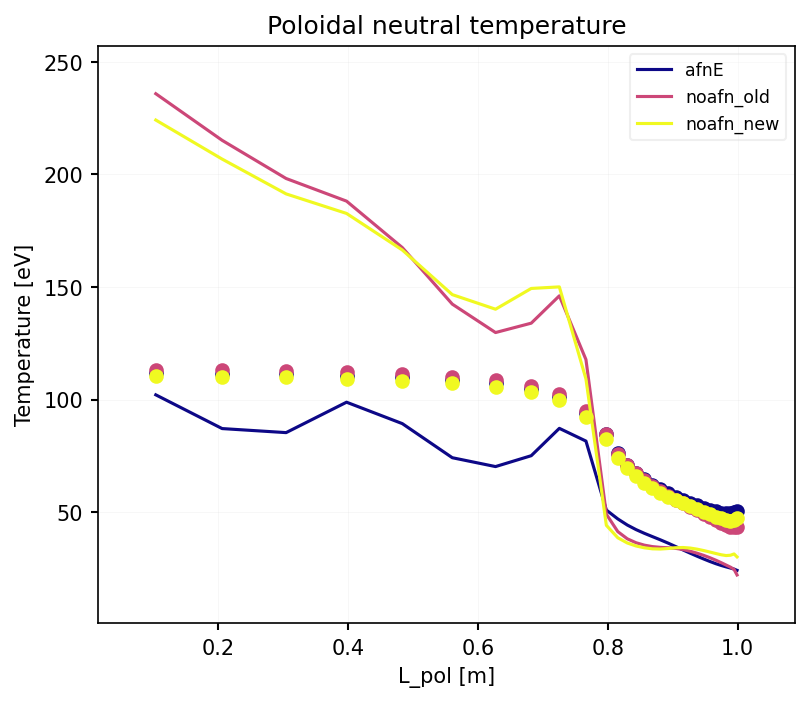

In [8]:
# locond = ['afnE', 'afnE_cond0.01', 'afnE_cond0.01_minmod_form1', 'afnE_cond0.01_minmod_form3', 'afnE_cond0.01_minmod_form2', 'afnE_cond0.25_form1', 'afnE_cond0.25_form2', 'afnE_cond0.25_form3', 'noafn_old', 'noafn_new']

locond = ['afnE', 'afnE_cond0.01', 'afnE_cond0.01_minmod_form1', 'afnE_cond0.01_minmod_form3', 'afnE_cond0.01_minmod_form2']
condlim = ['afnE', 'afnE_cond0.25_form1', 'afnE_cond0.25_form2', 'afnE_cond0.25_form3', 'afnE_cond0.25_form4']
standard = ['afnE', 'noafn_old', 'noafn_new']

for cases in [locond, condlim, standard]:
    colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
    fig, ax = plt.subplots(dpi = 150)

    for i, case in enumerate(cases):
        ds = casestore[case].ds.isel(t=-1)
        m = ds.metadata
        fl = ds.isel(x = m["ixseps1"], theta = slice(76,-2))
        dist = np.cumsum(fl["dl"])
        ax.plot(dist, fl["Td"], label = case, c = colors[i])
        ax.plot(dist, fl["Td+"], marker = "o", lw = 0, c = colors[i])
    # ax.set_yscale("symlog", linthresh = 1e-3)
    ax.set_xlabel("L_pol [m]")
    ax.set_ylabel("Temperature [eV]")
    ax.set_title("Poloidal neutral temperature")
    ax.legend(fontsize="small")

## Look deeper into MC cases

C:\Users\mikek\AppData\Local\Temp\ipykernel_68208\3589793691.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))


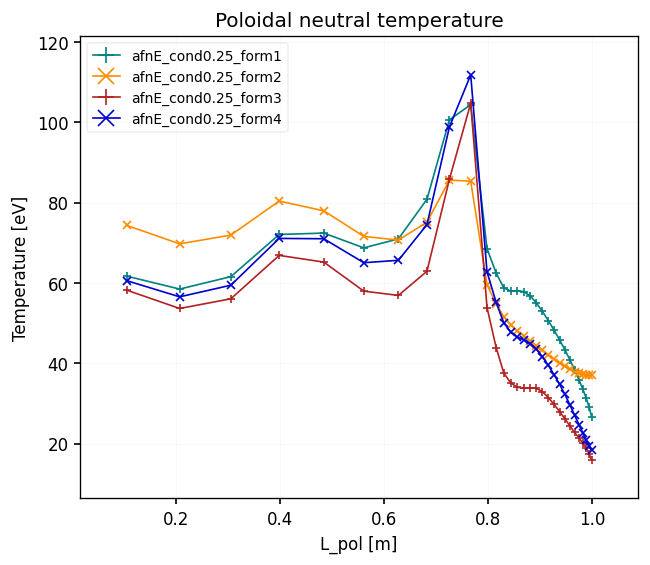

In [6]:
# locond = ['afnE', 'afnE_cond0.01', 'afnE_cond0.01_minmod_form1', 'afnE_cond0.01_minmod_form3', 'afnE_cond0.01_minmod_form2', 'afnE_cond0.25_form1', 'afnE_cond0.25_form2', 'afnE_cond0.25_form3', 'noafn_old', 'noafn_new']


condlim = [
    'afnE_cond0.25_form1', 
    'afnE_cond0.25_form2', 
    'afnE_cond0.25_form3', 
    'afnE_cond0.25_form4'
    ]


for cases in [condlim]:
    colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
    fig, ax = plt.subplots(dpi = 120)

    for i, case in enumerate(cases):
        ds = casestore[case].ds.isel(t=-1)
        m = ds.metadata
        fl = ds.isel(x = m["ixseps1"], theta = slice(76,-2))
        dist = np.cumsum(fl["dl"])
        
        if any([x in case for x in ["form2", "form4"]]):
            m = "x"
        elif any([x in case for x in ["form1", "form3"]]):
            m = "+"
        else:
            m = "x"
        ax.plot(dist, fl["Td"], label = case, marker = m, ms = 5, lw = 1)
    # ax.set_yscale("symlog", linthresh = 1e-3)
    ax.set_xlabel("L_pol [m]")
    ax.set_ylabel("Temperature [eV]")
    ax.set_title("Poloidal neutral temperature")
    ax.legend(fontsize="small")

### Perp advection

C:\Users\mikek\AppData\Local\Temp\ipykernel_68208\715728164.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))


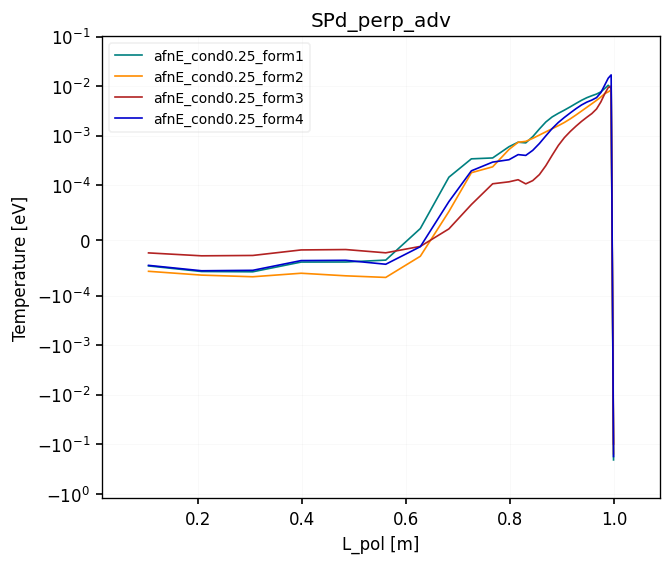

In [8]:
param = "SPd_perp_adv"

condlim = [
    'afnE_cond0.25_form1', 
    'afnE_cond0.25_form2', 
    'afnE_cond0.25_form3', 
    'afnE_cond0.25_form4'
    ]

for cases in [condlim]:
    colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
    fig, ax = plt.subplots(dpi = 120)

    for i, case in enumerate(cases):
        ds = casestore[case].ds.isel(t=-1)
        m = ds.metadata
        fl = ds.isel(x = m["ixseps1"], theta = slice(76,-2))
        dist = np.cumsum(fl["dl"]).values
        ax.plot(dist, fl[param], label = case, ms = 5, lw = 1)
    ax.set_yscale("symlog", linthresh = 1e-4)
    ax.set_xlabel("L_pol [m]")
    ax.set_ylabel("Temperature [eV]")
    ax.set_title(param)
    ax.legend(fontsize="small")

### Perp compression

C:\Users\mikek\AppData\Local\Temp\ipykernel_68208\3696904773.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))


Variable not found in afnE_cond0.25_form1


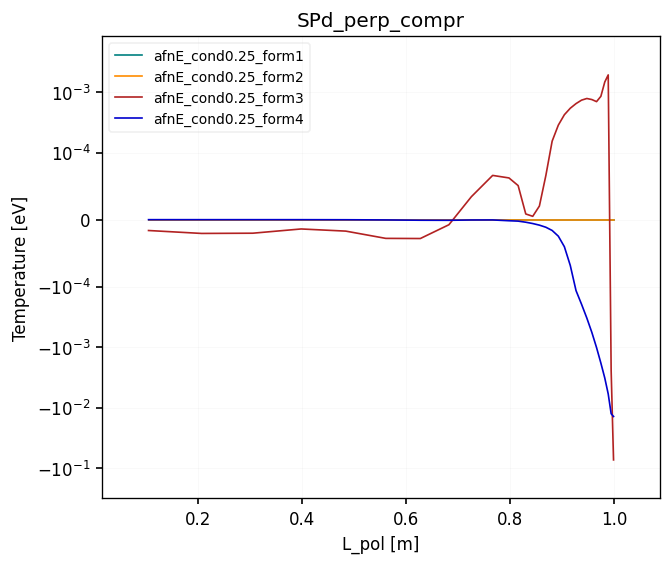

In [9]:
param = "SPd_perp_compr"

condlim = [
    'afnE_cond0.25_form1', 
    'afnE_cond0.25_form2', 
    'afnE_cond0.25_form3', 
    'afnE_cond0.25_form4'
    ]

for cases in [condlim]:
    colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
    fig, ax = plt.subplots(dpi = 120)

    for i, case in enumerate(cases):
        
        ds = casestore[case].ds.isel(t=-1)
        m = ds.metadata
        fl = ds.isel(x = m["ixseps1"], theta = slice(76,-2))
        dist = np.cumsum(fl["dl"]).values
        if "SPd_perp_compr" not in ds.data_vars:
            print(f"Variable not found in {case}")
            data = np.zeros_like(dist)
        else:
            data = fl[param]
        
        
        ax.plot(dist, data, label = case, ms = 5, lw = 1)
    ax.set_yscale("symlog", linthresh = 1e-4)
    ax.set_xlabel("L_pol [m]")
    ax.set_ylabel("Temperature [eV]")
    ax.set_title(param)
    ax.legend(fontsize="small")

In [12]:
casestore.keys()

dict_keys(['afnE', 'afnE_cond0.01', 'afnE_cond0.01_minmod_form1', 'afnE_cond0.01_minmod_form3', 'afnE_cond0.01_minmod_form2', 'afnE_cond0.25_form1', 'afnE_cond0.25_form2', 'afnE_cond0.25_form3', 'afnE_cond0.25_form4', 'noafn_old', 'noafn_new', 'afnE_cond0.25_CXx0.75', 'afnE_cond0.25_IZx0.75'])

C:\Users\mikek\AppData\Local\Temp\ipykernel_68208\3783312068.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))


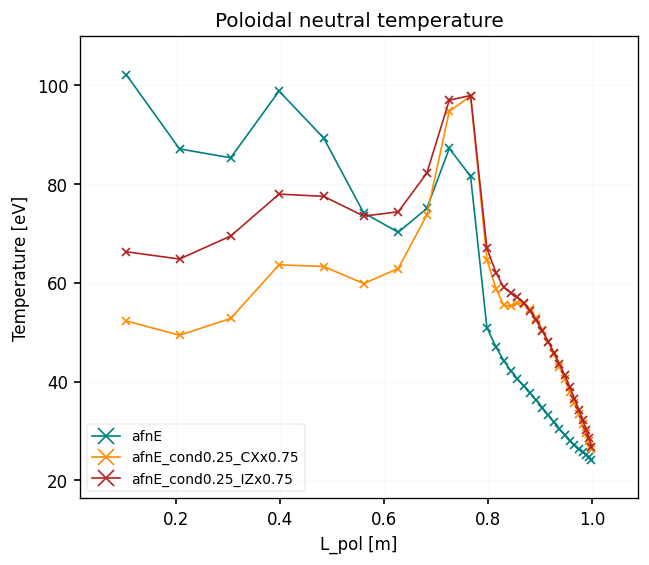

In [14]:
# locond = ['afnE', 'afnE_cond0.01', 'afnE_cond0.01_minmod_form1', 'afnE_cond0.01_minmod_form3', 'afnE_cond0.01_minmod_form2', 'afnE_cond0.25_form1', 'afnE_cond0.25_form2', 'afnE_cond0.25_form3', 'noafn_old', 'noafn_new']


condlim = [
    'afnE', 
    'afnE_cond0.25_CXx0.75', 
    'afnE_cond0.25_IZx0.75', 
    # 'afnE_cond0.25_form4'
    ]


for cases in [condlim]:
    colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
    fig, ax = plt.subplots(dpi = 120)

    for i, case in enumerate(cases):
        ds = casestore[case].ds.isel(t=-1)
        m = ds.metadata
        fl = ds.isel(x = m["ixseps1"], theta = slice(76,-2))
        dist = np.cumsum(fl["dl"])
        
        if any([x in case for x in ["form2", "form4"]]):
            m = "x"
        elif any([x in case for x in ["form1", "form3"]]):
            m = "+"
        else:
            m = "x"
        ax.plot(dist, fl["Td"], label = case, marker = m, ms = 5, lw = 1)
    # ax.set_yscale("symlog", linthresh = 1e-3)
    ax.set_xlabel("L_pol [m]")
    ax.set_ylabel("Temperature [eV]")
    ax.set_title("Poloidal neutral temperature")
    ax.legend(fontsize="small")

# Calculate KE

In [ ]:
fig, ax = plt.subplots()

ds = casestore["afnE_mfp1_cond0.01"].ds

vperp = ds["pf_perp_diff_R_d"] * ds["dr"]  # s-1 * m = m/s
vpar = 

# Look at Td in all cases

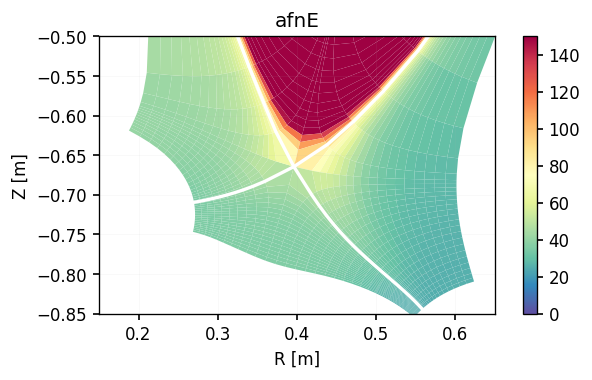

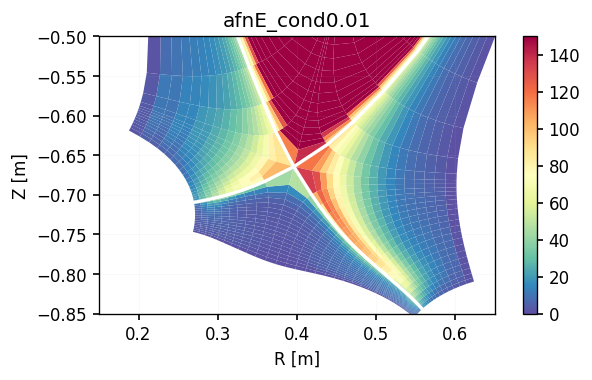

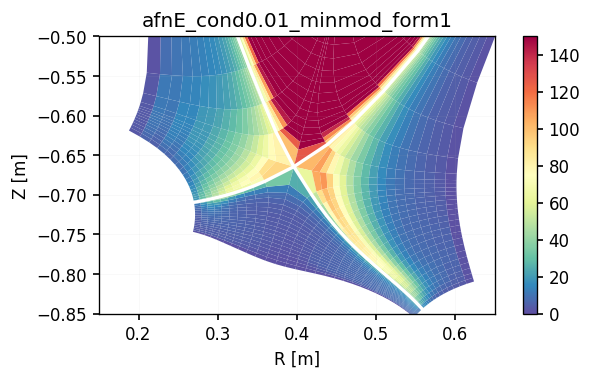

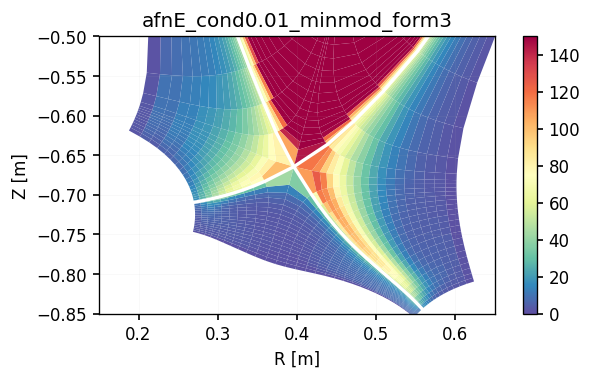

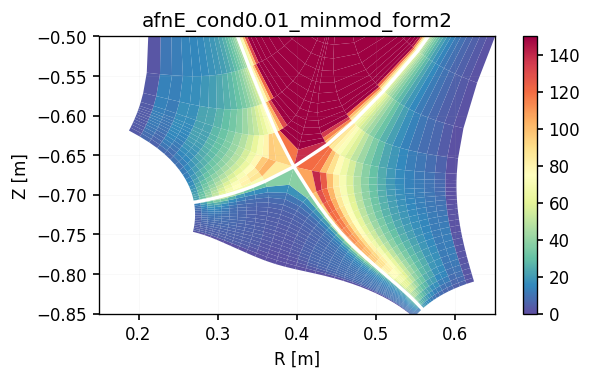

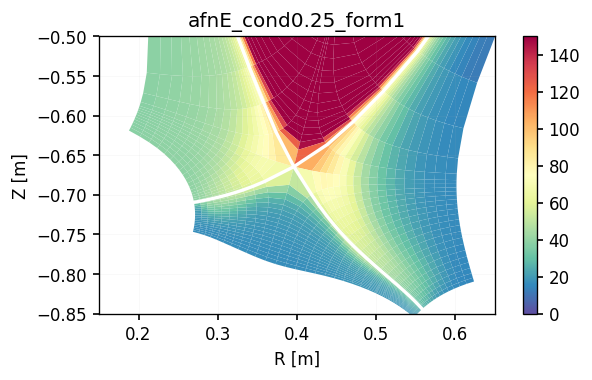

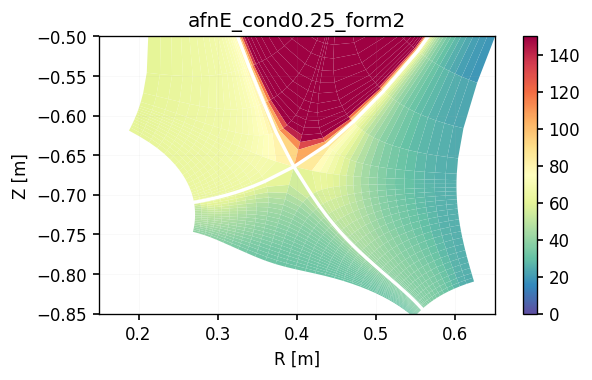

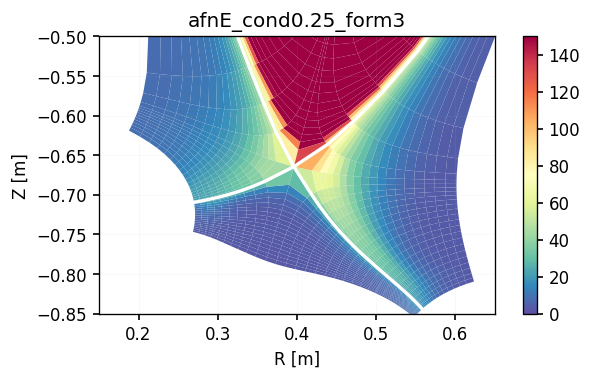

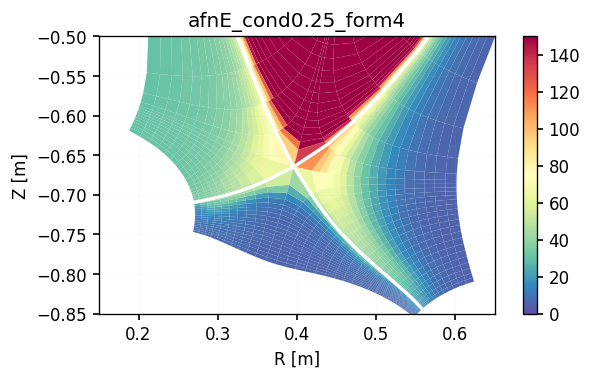

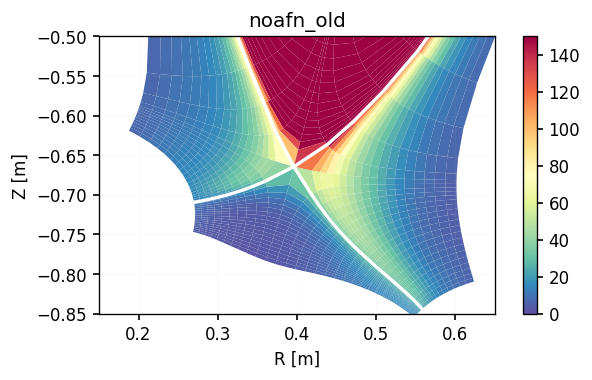

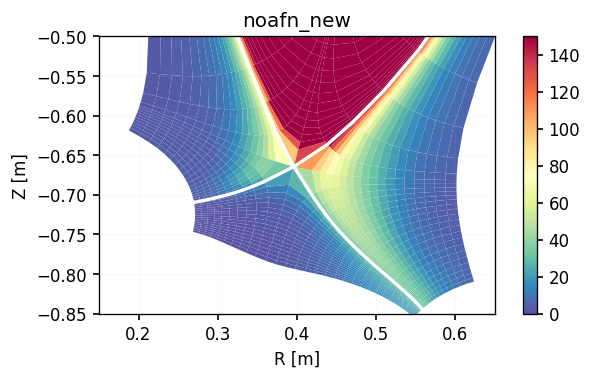

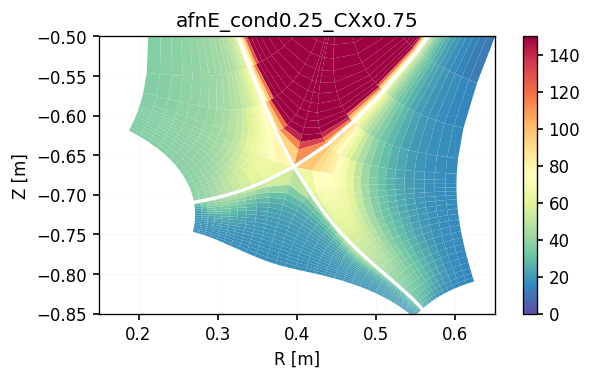

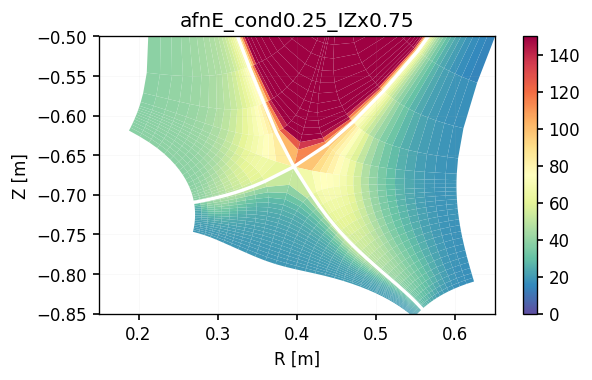

In [10]:
for case in [x for x in casestore.keys() if "notune" not in x]:
    fig, ax = plt.subplots(figsize = (6,3))
    ds = casestore[case].ds.isel(t=-1)
    ds["Td"].hermesm.clean_guards().bout.polygon(ax, cmap = "Spectral_r", vmax = 150, vmin = 0, antialias = True)
    ax.set_ylim(-0.85, -0.5)
    ax.set_xlim(0.15,0.65)
    ax.set_title(case)